In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import PIL.Image
import numpy as np
import tqdm

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.nn import init
from matplotlib import pyplot as plt

torch.manual_seed(1)
torch.cuda.manual_seed(1)
PIL.Image.LOAD_TRUNCATED_IMAGES = True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

if not os.path.isdir('targetdir/'):
  with zipfile.ZipFile("drive/MyDrive/Data/RealPhotos.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")

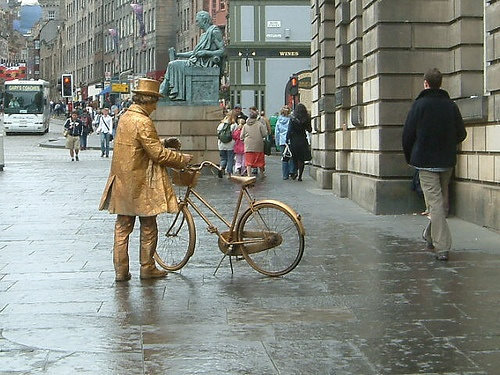

In [5]:
from IPython.display import Image, display
display(Image('targetdir/JPEGImages/2007_000793.jpg', width = 400, height = 400))

In [ ]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 256, 256)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 256, 256)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [ ]:
path = "targetdir/JPEGImages/"
batch_size = 32 

class RealPhotosDataset(Dataset):
    def __init__(self, directory):
        self.files = [os.path.join(directory, f) for f in os.listdir(directory)]

    def __getitem__(self, index):
        img = PIL.Image.open(self.files[index]).convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img) / 255.0
        img = np.transpose(img,(2,0,1)).astype('float32')
        return torch.tensor(img-0.5)
    
    def __len__(self):
      return len(self.files)

data_set = RealPhotosDataset(path)

train_len = int(len(data_set) * 0.9)
train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_set, batch_size=4, num_workers=5)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1,padding=1,bias=False);
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1,padding=1,bias=False);
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity

        return out


class ConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=3,strides=2,pad=1):
        super(ConvBNR, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));


class TransposeConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=4,strides=2,pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1= nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));


class VAE2_encoder(nn.Module):
    def __init__(self,in_channels=3,n_res_blocks=4,n_layers=3):
        super(VAE2_encoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        self.ch2im=nn.ModuleList()

        for j in range(n_layers):
            self.ch2im.append(nn.Conv2d(in_channels, 64, kernel_size=1, stride=1))
            self.layer.append(ConvBNR(64,64));

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        self.ch2im.append(nn.Conv2d(in_channels, 64, kernel_size=1, stride=1))
        for j in range(n_res_blocks):
           self.res_blks.append(ReNetBlock(64,64))

        self.max_steps= 4;

    def forward(self, x,steps):
        x=self.ch2im[steps-1](x);
        for inds,j in enumerate(range(self.n_layers)):
          if((self.max_steps-inds)<=steps):
            x= self.layer[j](x)

        if(steps<self.max_steps):
          for inds,j in enumerate(range(self.n_res_blocks)):
              x=self.res_blks[j](x);     
        return x


class VAE2_decoder(nn.Module):
    def __init__(self,in_channels=64,out_channel=3,n_res_blocks=4,n_layers=3):
        super(VAE2_decoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        self.ch2im=nn.ModuleList()

        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64,64,pad=1));
            self.ch2im.append(nn.Conv2d(64, out_channel, kernel_size=1, stride=1))

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))
        self.ch2im.append(nn.Conv2d(64, out_channel, kernel_size=1, stride=1))

        self.max_steps= 4;

    def forward(self, x,steps):
        for inds,j in enumerate(range(self.n_res_blocks)):
            x=self.res_blks[j](x);
            
        for inds,j in enumerate(range(self.n_layers)):
          if((self.max_steps-inds)<=steps):
            x= self.layer[j](x)

        x=self.ch2im[steps-1](x);
        return x


class VAE2(nn.Module):
  def __init__(self,z_dim=512):
        super(VAE2, self).__init__()
        self.n_layers=3;
        self.down_fact=2**(self.n_layers);
        down_img_size=256//self.down_fact;
        self.fdim=(down_img_size)**2*64
        print('bottle neck image resolution '+str(down_img_size))
        print('bottle neck dim is '+str(self.fdim)+'..!')
        self.size=[64,down_img_size,down_img_size]
        self.encoder=VAE2_encoder(n_layers=self.n_layers)
        self.decoder=VAE2_decoder(n_layers=self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)

  def flat(self, input):
        return input.view(input.size(0),1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar=logvar*1e-3 #lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x,steps):
      h = self.encoder(x,steps)
      h=self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z,steps):
      z = self.fc3(z)
      z_img=self.unflat(z);
      z = self.decoder(z_img,steps)
      return z,z_img

  def forward(self, x,steps=5):
      z, mu, logvar = self.encode(x,steps)
      z,z_out = self.decode(z,steps)
      return z, mu, logvar,z_out

In [ ]:
class PatchGAN(nn.Module):
    def __init__(self, input_dim, ndf=16, n_layers=3, norm_layer=nn.BatchNorm2d,max_steps=4):
        super(PatchGAN, self).__init__()
        use_bias = False
        self.max_steps=max_steps

        kernel_size = 4
        padw = 1
        self.sequence=nn.ModuleList()
        self.im2ch=nn.ModuleList()
        #self.sequence += [nn.Sequential(nn.Conv2d(input_dim, ndf, kernel_size=kernel_size, stride=2, padding=padw), nn.LeakyReLU(0.2, True))]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(0, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            self.sequence += [nn.Sequential(
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kernel_size, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True))
            ]
            self.im2ch.append(nn.Conv2d(input_dim, ndf * nf_mult_prev, kernel_size=1))

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        self.sequence += [nn.Sequential(
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kernel_size, stride=2, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True))
        ]
        self.im2ch.append(nn.Conv2d(input_dim, ndf * nf_mult_prev, kernel_size=1))

        self.final_conv = nn.Conv2d(ndf * nf_mult, 1, kernel_size=kernel_size, stride=1, padding=padw)  # output 1 channel prediction map



    def forward(self, input,steps=5):
        #print(input.shape)
        x=self.im2ch[self.max_steps-steps](input)
        for j in range(self.max_steps-steps,self.max_steps):
            #print(x.shape)
            x=self.sequence[j](x)
        x=self.final_conv(x)
        return x


class ConvBNRelu(nn.Module):
    def __init__(self, nin,nout,stride=2):
        super(ConvBNRelu, self).__init__()
        self.layer=nn.Sequential(nn.Conv2d(in_channels = nin,out_channels = nout,kernel_size = 4,stride = stride,padding = 1,bias = False),
                  nn.BatchNorm2d(nout),
                  nn.LeakyReLU(0.2, inplace=True))
    def forward(self, x):
        return self.layer(x);


class Discriminator(nn.Module):
    def __init__(self,nChannels=64, ndf=64):
        super(Discriminator, self).__init__()
        self.layer1 = ConvBNRelu(nChannels,ndf,stride=2); 
        self.layer2 =  ConvBNRelu(ndf,ndf*2,stride=2); 
        self.layer3 =  ConvBNRelu(ndf*2,ndf*4,stride=2); 
        self.layer4 =  ConvBNRelu(ndf*4,ndf*8,stride=2); 
        self.layer5 =   ConvBNRelu(ndf*8,1,stride=1); 
        self.final = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size = 1,stride = 1)

    def forward(self, x):
        out = self.layer1(x);
        out = self.layer2(out);
        out = self.layer3(out);
        out = self.layer4(out)
        out = self.layer5(out);
        out=self.final(out);
        return out

bottle neck image resolution 32
bottle neck dim is 65536..!


Epoch 0:   0%|          | 0/482 [00:00<?, ?batch/s]

running gan step1


Epoch 0: 100%|██████████| 482/482 [02:12<00:00,  3.64batch/s, D_loss=1.14, G_los=1.09, kl_loss=1.92, l1_loss=2.4, loss=5.42]


torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 32, 32])


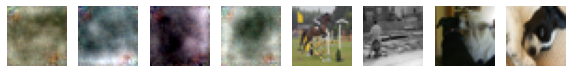

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step2


Epoch 1: 100%|██████████| 482/482 [02:23<00:00,  3.37batch/s, D_loss=1.66, G_los=1.83, kl_loss=1.28, l1_loss=3.55, loss=6.66]


torch.Size([4, 3, 64, 64]) torch.Size([4, 3, 64, 64])


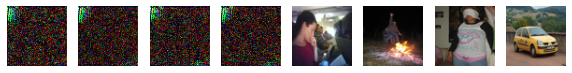

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step3


Epoch 2: 100%|██████████| 482/482 [02:44<00:00,  2.93batch/s, D_loss=2.48, G_los=2.59, kl_loss=1.5, l1_loss=4.44, loss=8.53]


torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128])


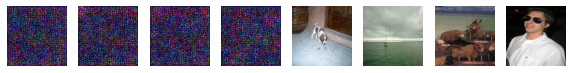

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 3: 100%|██████████| 482/482 [03:38<00:00,  2.20batch/s, D_loss=2.9, G_los=2.97, kl_loss=1.25, l1_loss=4.84, loss=9.07]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


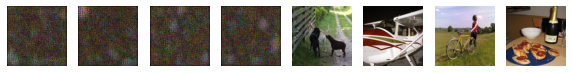

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 4: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.16, G_los=3.2, kl_loss=1.1, l1_loss=5.09, loss=9.39]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


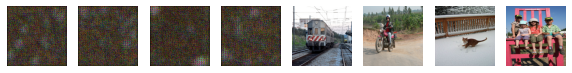

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 5: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.33, G_los=3.35, kl_loss=1, l1_loss=5.25, loss=9.6]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


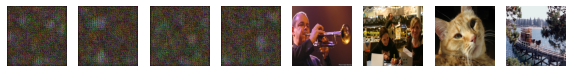

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 6: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.45, G_los=3.45, kl_loss=0.934, l1_loss=5.37, loss=9.75]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


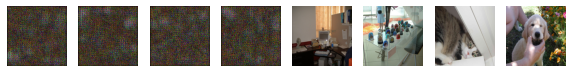

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 7: 100%|██████████| 482/482 [03:37<00:00,  2.22batch/s, D_loss=3.54, G_los=3.53, kl_loss=0.881, l1_loss=5.45, loss=9.87]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


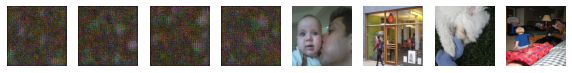

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 8: 100%|██████████| 482/482 [03:36<00:00,  2.22batch/s, D_loss=3.61, G_los=3.6, kl_loss=0.839, l1_loss=5.52, loss=9.96]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


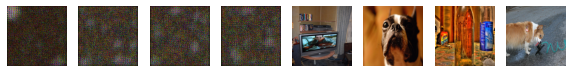

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 9: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.67, G_los=3.65, kl_loss=0.806, l1_loss=5.57, loss=10]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


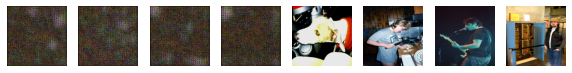

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 10: 100%|██████████| 482/482 [03:37<00:00,  2.22batch/s, D_loss=3.72, G_los=3.69, kl_loss=0.779, l1_loss=5.62, loss=10.1]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


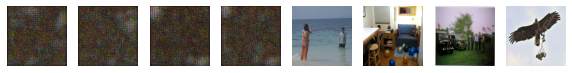

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 11: 100%|██████████| 482/482 [03:37<00:00,  2.22batch/s, D_loss=3.75, G_los=3.72, kl_loss=0.756, l1_loss=5.66, loss=10.1]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


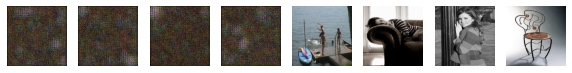

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 12: 100%|██████████| 482/482 [03:36<00:00,  2.22batch/s, D_loss=3.79, G_los=3.75, kl_loss=0.737, l1_loss=5.69, loss=10.2]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


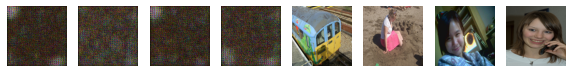

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 13: 100%|██████████| 482/482 [03:37<00:00,  2.22batch/s, D_loss=3.82, G_los=3.78, kl_loss=0.721, l1_loss=5.71, loss=10.2]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


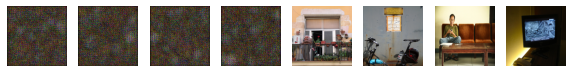

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 14: 100%|██████████| 482/482 [03:36<00:00,  2.22batch/s, D_loss=3.84, G_los=3.8, kl_loss=0.707, l1_loss=5.74, loss=10.2]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


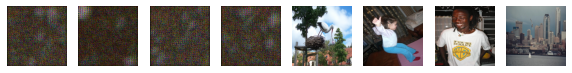

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 15: 100%|██████████| 482/482 [03:37<00:00,  2.21batch/s, D_loss=3.86, G_los=3.82, kl_loss=0.694, l1_loss=5.76, loss=10.3]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


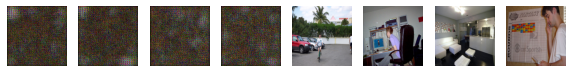

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 16: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.88, G_los=3.83, kl_loss=0.683, l1_loss=5.78, loss=10.3]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


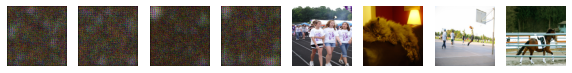

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 17: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.9, G_los=3.85, kl_loss=0.673, l1_loss=5.79, loss=10.3]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


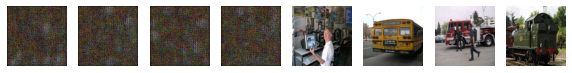

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 18: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.91, G_los=3.86, kl_loss=0.665, l1_loss=5.81, loss=10.3]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


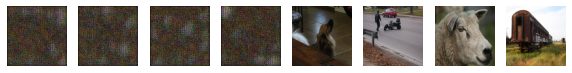

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 19: 100%|██████████| 482/482 [03:36<00:00,  2.22batch/s, D_loss=3.92, G_los=3.87, kl_loss=0.657, l1_loss=5.82, loss=10.3]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


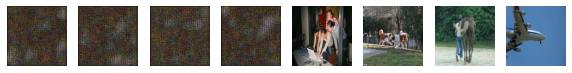

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 20: 100%|██████████| 482/482 [03:36<00:00,  2.22batch/s, D_loss=3.94, G_los=3.88, kl_loss=0.65, l1_loss=5.83, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


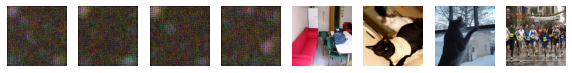

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 21: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.95, G_los=3.89, kl_loss=0.643, l1_loss=5.84, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


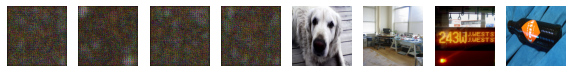

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 22: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.96, G_los=3.9, kl_loss=0.637, l1_loss=5.85, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


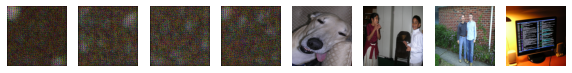

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 23: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.97, G_los=3.91, kl_loss=0.632, l1_loss=5.86, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


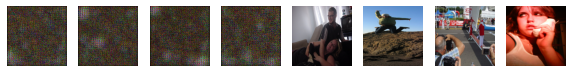

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 24: 100%|██████████| 482/482 [03:36<00:00,  2.22batch/s, D_loss=3.98, G_los=3.92, kl_loss=0.627, l1_loss=5.87, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


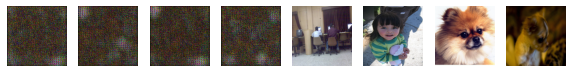

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 25: 100%|██████████| 482/482 [03:36<00:00,  2.22batch/s, D_loss=3.98, G_los=3.92, kl_loss=0.622, l1_loss=5.87, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


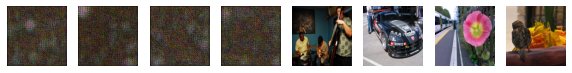

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 26: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=3.99, G_los=3.93, kl_loss=0.618, l1_loss=5.88, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


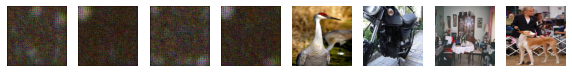

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 27: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=4, G_los=3.94, kl_loss=0.614, l1_loss=5.89, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


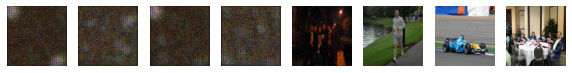

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 28: 100%|██████████| 482/482 [03:36<00:00,  2.23batch/s, D_loss=4, G_los=3.94, kl_loss=0.61, l1_loss=5.89, loss=10.4]


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


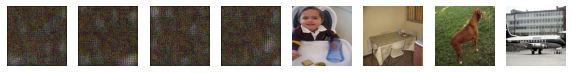

  0%|          | 0/482 [00:00<?, ?batch/s]

running gan step4


Epoch 29:  59%|█████▉    | 284/482 [02:07<01:28,  2.23batch/s, D_loss=4.01, G_los=3.95, kl_loss=0.608, l1_loss=5.9, loss=10.5]


KeyboardInterrupt: ignored

In [ ]:
netG=VAE2().to(device);
netD=PatchGAN(3).to(device)
learning_rate = 0.001

optD = torch.optim.Adam(
    netD.parameters(),
    lr=learning_rate, betas=(0.5, 0.999)
)
optG = torch.optim.Adam(
    netG.parameters(),
    lr=learning_rate, betas=(0.5, 0.999)
)

epochs = 100
decayRate = 0.99
lrdecay_schedulerD = torch.optim.lr_scheduler.ExponentialLR(optimizer=optD, gamma=decayRate)
lrdecay_scheduleG = torch.optim.lr_scheduler.ExponentialLR(optimizer=optG, gamma=decayRate)

costs=[];
lossL1=torch.nn.L1Loss();
means=[];
logvars=[];
steps=0;
gan_step=0;
max_steps=4;
AdvBCELoss = nn.BCEWithLogitsLoss()
real_label = 1.
fake_label = 0.

for epoch in range(0, epochs + 1):
      gan_step=gan_step+1
      if(gan_step>max_steps):
        gan_step=max_steps;
      ds=2**(max_steps-gan_step)
      print('running gan step'+str(gan_step))
      data_set = RealPhotosDataset(path,ds)
      train_len = int(len(data_set)*0.9)
      train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

      train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_set, batch_size=4)
      netG.train()
      netD.train()

      with tqdm.tqdm(train_loader, total=int(len(train_loader)), unit="batch",position=0, leave=True) as tepoch:
        for x in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            x = x.to(device)
            x_hat, mu, logvar,_ = netG(x,gan_step)
            is_fake_det = netD(x_hat.detach().to(device),gan_step)
            is_real = netD(x,gan_step)
            label_real = torch.full(is_fake_det.shape, real_label, dtype=torch.float, device=device)
            label_fake = torch.full(is_fake_det.shape, fake_label, dtype=torch.float, device=device)
            lossD=AdvBCELoss(is_real, label_real)+AdvBCELoss(is_fake_det,label_fake)
            optD.zero_grad()
            lossD.backward()
            optD.step()

            is_fake = netD(x_hat,gan_step)
            loss_GAN = AdvBCELoss(is_fake,label_real)
            loss_l1=lossL1(x_hat, x)*10.0
            loss_kl=0.5 * torch.mean(logvar.exp() - logvar - 1.0 + mu**2)
            lossG=loss_GAN+loss_l1+loss_kl;
            optG.zero_grad()
            lossG.backward()

            optG.step()
            lrdecay_schedulerD.step()
            lrdecay_scheduleG.step()

            costs.append([loss_GAN.item(), lossD.item(), loss_l1.item(), loss_kl.item(), lossG.item()])
            err=np.asarray(costs).mean(0);
            tepoch.set_postfix(loss=err[-1], l1_loss=err[-3], kl_loss=err[-2],G_los=err[0],D_loss=err[1])

      # Testing
      with torch.no_grad():
          netG.eval()
          test_loss = 0.0
          for ix,x in enumerate(test_loader):
              x = x.to(device)
              x_hat, mu, logvar,_ = netG(x,gan_step)
              loss=0.0;
              loss+=lossL1(x_hat, x)*10.0
              loss+=0.5 * torch.mean(logvar.exp() - logvar - 1.0 + mu**2)

              test_loss+=loss.item();
              if(ix<1):
                print(x.shape,x_hat.shape)
                plt.figure(figsize=(10, 4))

                for i in range(4):
                    plt.subplot(1,8,i+1)
                    plt.imshow(np.clip(x_hat.detach().cpu().numpy()[i,:,:,:].transpose(1,2,0),0.0,1.0))
                    plt.axis('off')

                for i in range(4):
                    plt.subplot(1,8,i+1+4)
                    plt.imshow(np.clip(x.detach().cpu().numpy()[i,:,:].transpose(1,2,0),0.0,1.0))
                    plt.axis('off')
                plt.show()